In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('results.xlsx')

In [3]:
df.drop(['Unnamed: 0', 'Sequence Num', 'phone_time', 'timestamp', 'valid','BRAmplitude'] , axis=1, inplace=True)

In [4]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [11])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [6]:
# index for feature importances
a=df.columns
a = a.drop(['gender','cals'])
a = a.insert(0,'male')
a = a.insert(0,'female')

In [7]:
# Get unique values in column i
unique_values = np.unique(X[:, -1])

# Dictionary to store indices for each unique value
indices_dict = {}

# Iterate over unique values
for value in unique_values:
    indices = np.where(X[:, -1] == value)[0]
    indices_dict[value] = [indices[0],indices[-1]]

print("Indices for each unique value in:")
for value, indices in indices_dict.items():
    print("Value:", value, "Indices:", indices)

Indices for each unique value in:
Value: 9467 Indices: [1505, 2104]
Value: 11073 Indices: [2699, 3298]
Value: 12108 Indices: [1093, 1504]
Value: 12890 Indices: [493, 1092]
Value: 13002 Indices: [2105, 2698]
Value: 13673 Indices: [0, 492]
Value: 13720 Indices: [3723, 4322]
Value: 13942 Indices: [3299, 3722]
Value: 14173 Indices: [4572, 5059]
Value: 14711 Indices: [4323, 4571]


In [8]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


num_subjects = 10

# Extract the indices corresponding to each subject's data
subject_indices = [np.arange(indices[0], indices[1]+1) for indices in indices_dict.values()]

# Define the number of folds for subject-wise cross-validation
k = num_subjects

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Initialize the KFold object with subject-wise splitting
kf = KFold(n_splits=k)

# Initialize a list to store the mean squared errors (MSE) for each fold
mse_scores = []

# Perform subject-wise cross-validation
for train_index, test_index in kf.split(range(num_subjects)):
    # Extract the indices corresponding to the current training and testing subjects
    train_indices = np.concatenate([subject_indices[i] for i in train_index])
    test_indices = np.concatenate([subject_indices[i] for i in test_index])
    
    # Extract the training and testing data for the current fold
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # Train the model on the training data
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = rf_model.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    # Append the MSE to the list of scores
    mse_scores.append(mse)

# Calculate the mean and standard deviation of the MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean Squared Error: {mse_scores}")
print(f"Mean Squared Error: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

Mean Squared Error: [0.0024921207164659933, 0.001560645734385787, 0.004803015821613721, 0.0018463537165836438, 0.0024186029468174185, 0.00036848323615444367, 0.0008201071791691898, 0.00024403677464651162, 0.00031415517765640786, 0.0002532648289142184]
Mean Squared Error: 0.0015120786132407338
Standard Deviation of MSE: 0.001383503988736861


In [9]:
print(f"RootMean Squared Error: {np.sqrt(mse_scores)}")

RootMean Squared Error: [0.04992114 0.03950501 0.06930379 0.04296922 0.04917929 0.01919592
 0.02863751 0.01562168 0.01772442 0.0159143 ]


In [10]:
print(f"mean of Root Mean Squared Error: {np.mean(np.sqrt(mse_scores))}")

mean of Root Mean Squared Error: 0.034797228646238854


In [11]:
from sklearn.model_selection import BaseCrossValidator

class SubjectKFold(BaseCrossValidator):
    def __init__(self, num_subjects):
        self.num_subjects = num_subjects

    def split(self, X, y=None, groups=None):
        subject_indices = [np.arange(indices[0], indices[1] + 1) for indices in indices_dict.values()]
        for train_index, test_index in KFold(n_splits=self.num_subjects).split(subject_indices):
            train_indices = np.concatenate([subject_indices[i] for i in train_index])
            test_indices = np.concatenate([subject_indices[i] for i in test_index])
            yield train_indices, test_indices
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.num_subjects

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Define the hyperparameters you want to tune
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the trees
    #'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split a node
    #'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Initialize the custom cross-validation splitter
subject_kfold = SubjectKFold(num_subjects=10)

# Initialize the GridSearchCV object with the RandomForestRegressor, parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=subject_kfold, scoring='neg_root_mean_squared_error', verbose=5)

# Perform grid search with cross-validation
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model using cross-validation
cv_results = cross_val_score(best_model, X, y, cv=subject_kfold, scoring='neg_root_mean_squared_error')

# Calculate the mean and standard deviation of the cross-validation scores
mean_cv_score = np.mean(cv_results)
std_cv_score = np.std(cv_results)

print(cv_results)
print(f"Mean Cross-Validation Score: {mean_cv_score}")
print(f"Standard Deviation of Cross-Validation Score: {std_cv_score}")


Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10] END .max_depth=None, n_estimators=10;, score=-0.053 total time=   0.4s
[CV 2/10] END .max_depth=None, n_estimators=10;, score=-0.039 total time=   0.4s
[CV 3/10] END .max_depth=None, n_estimators=10;, score=-0.070 total time=   0.4s
[CV 4/10] END .max_depth=None, n_estimators=10;, score=-0.040 total time=   0.4s
[CV 5/10] END .max_depth=None, n_estimators=10;, score=-0.049 total time=   0.4s
[CV 6/10] END .max_depth=None, n_estimators=10;, score=-0.019 total time=   0.4s
[CV 7/10] END .max_depth=None, n_estimators=10;, score=-0.030 total time=   0.4s
[CV 8/10] END .max_depth=None, n_estimators=10;, score=-0.016 total time=   0.4s
[CV 9/10] END .max_depth=None, n_estimators=10;, score=-0.021 total time=   0.4s
[CV 10/10] END max_depth=None, n_estimators=10;, score=-0.017 total time=   0.4s
[CV 1/10] END .max_depth=None, n_estimators=50;, score=-0.054 total time=   2.1s
[CV 2/10] END .max_depth=None, n_estimators=50

[CV 2/10] END ..max_depth=20, n_estimators=100;, score=-0.039 total time=   4.3s
[CV 3/10] END ..max_depth=20, n_estimators=100;, score=-0.069 total time=   4.4s
[CV 4/10] END ..max_depth=20, n_estimators=100;, score=-0.044 total time=   4.5s
[CV 5/10] END ..max_depth=20, n_estimators=100;, score=-0.049 total time=   4.2s
[CV 6/10] END ..max_depth=20, n_estimators=100;, score=-0.020 total time=   4.3s
[CV 7/10] END ..max_depth=20, n_estimators=100;, score=-0.029 total time=   4.7s
[CV 8/10] END ..max_depth=20, n_estimators=100;, score=-0.017 total time=   4.3s
[CV 9/10] END ..max_depth=20, n_estimators=100;, score=-0.018 total time=   4.3s
[CV 10/10] END .max_depth=20, n_estimators=100;, score=-0.017 total time=   4.7s
[CV 1/10] END ..max_depth=20, n_estimators=200;, score=-0.052 total time=   8.3s
[CV 2/10] END ..max_depth=20, n_estimators=200;, score=-0.039 total time=   8.7s
[CV 3/10] END ..max_depth=20, n_estimators=200;, score=-0.069 total time=   8.8s
[CV 4/10] END ..max_depth=20

In [13]:
# Splitting the dataset 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [34]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [35]:
y_pred = regressor.predict(X_test)

In [36]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9597562286388268

In [37]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

0.009410935294948207

In [38]:
feature_importances = pd.DataFrame(regressor.feature_importances_,index=a, columns=['importance']).sort_values('importance',ascending=False)

In [39]:
feature_importances

,importance
ZMin,0.396021
HR,0.165845
weight,0.088342
BR,0.074952
age,0.055975
ZPeak,0.053554
height,0.037943
Activity,0.034990
XMin,0.019264
YMin,0.018475


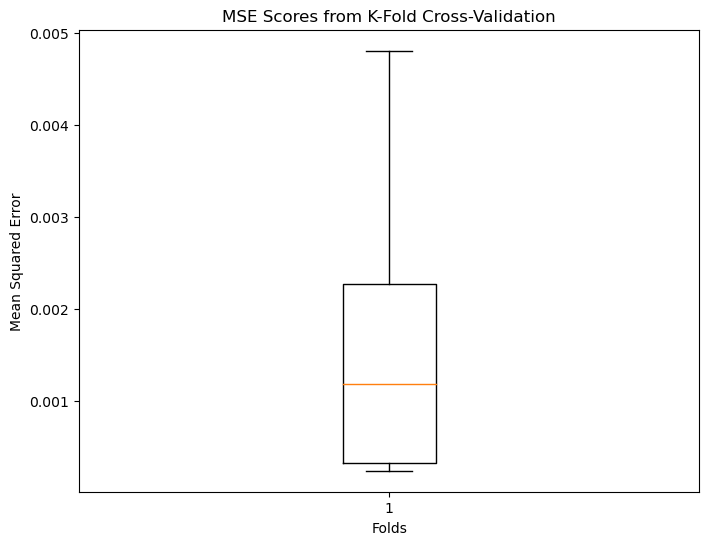

In [20]:
import matplotlib.pyplot as plt

# Assuming mse_scores contains the MSE scores from k-fold cross-validation

# Create a boxplot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(mse_scores)
plt.title('MSE Scores from K-Fold Cross-Validation')
plt.xlabel('Folds')
plt.ylabel('Mean Squared Error')
plt.show()

In [21]:
mse_scores

[0.0024921207164659933,
 0.001560645734385787,
 0.004803015821613721,
 0.0018463537165836438,
 0.0024186029468174185,
 0.00036848323615444367,
 0.0008201071791691898,
 0.00024403677464651162,
 0.00031415517765640786,
 0.0002532648289142184]